In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('abcnews-date-text.csv', error_bad_lines=False);
data_text = data[['headline_text']]
data_text['index'] = data_text.index
documents = data_text

In [3]:
data_text.head()

,headline_text,index
0,aba decides against community broadcasting lic...,0
1,act fire witnesses must be aware of defamation,1
2,a g calls for infrastructure protection summit,2
3,air nz staff in aust strike for pay rise,3
4,air nz strike to affect australian travellers,4


### LDA 

LDA : Latent Dirichlet Allocation

An unsupervised model that finds the hidden(latent) themes in a corpus.

If you have a corpus of say 'n' documents , LDA follows the following :

 -Go through each document and *randomly* assign each word in the document to one of the k topics 
 
                                         |
                                         |
                                        \|/
                    
                    This gives the topic representation of docs
                                        &
                        Word Distribution of all the topics      
                        

Iteratively , 
 
Go through each word 'w' in d and calculate
    
     -p(topic t | document d) = proportion of words in document d that are currently assigned to topic 't'
     
     -p(word w | topic t) = proportion of assignments to topic t over all documents that come from this word 'w'
     
Reassign 'w' a new topic with probability 

      - p(t|d) * p(w|t)
 


## Data Pre-processing
We will perform the following steps:

* Tokenization: Split the text into sentences and the sentences into words. Lowercase the words and remove punctuation.


* Words that have fewer than 3 characters are removed.


* All stopwords are removed.


* Words are lemmatized — words in third person are changed to first person and verbs in past and future tenses are changed into present.\n


* Words are stemmed — words are reduced to their root form.

In [4]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(100)
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/swapnil/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

###### Function to perform lemmatize and stem preprocessing steps on the data set.

In [5]:
stemmer = SnowballStemmer('english')

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

In [6]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [7]:
doc_sample = documents[documents['index'] == 4310].values[0][0]

print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))


original document: 
['rain', 'helps', 'dampen', 'bushfires']


 tokenized and lemmatized document: 
['rain', 'help', 'dampen', 'bushfir']


In [8]:
processed_docs = documents.sample(100000)['headline_text'].map(preprocess)

In [9]:
processed_docs[:10]

215997               [mcgrath, prepar, stay, wicket]
429573                 [aust, right, debat, reignit]
517853            [australia, west, indi, highlight]
616360                                            []
560947              [trickett, return, stall, block]
283683                [labour, crush, death, mumbai]
382453               [bike, southern, network, plan]
795113                 [tourist, miss, remot, coast]
342020          [tourist, involv, perth, crash, die]
715442    [north, west, sign, chines, tourism, push]
Name: headline_text, dtype: object

### Bag of words on the dataset¶

In [10]:
dictionary = gensim.corpora.Dictionary(processed_docs)

In [11]:
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

1978 rhetor
19382 clementin
328 pact
5128 bopha
9745 switzlerand
12709 booker
18340 whiskey
23171 hitlist
20843 lygon
2655 yanke
22077 cropper


#### Filter out tokens that appear in

* less than 5 documents (absolute number) or
* more than 0.3 documents (fraction of total corpus size, not absolute number).
* after the above two steps, keep only the first 10000 most frequent tokens.

In [12]:
dictionary.filter_extremes(no_below=5, no_above=0.3, keep_n=10000)

In [13]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[1000]

[(111, 1), (149, 1), (1103, 1), (1238, 1), (1694, 1)]

In [14]:
bow_doc_4310 = bow_corpus[1000]

for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], 
                                                     dictionary[bow_doc_4310[i][0]], 
                                                     bow_doc_4310[i][1]))

Word 111 ("hous") appears 1 time.
Word 149 ("support") appears 1 time.
Word 1103 ("senat") appears 1 time.
Word 1238 ("mix") appears 1 time.
Word 1694 ("superannu") appears 1 time.


## Running LDA using Bag of Words

In [15]:
lda_model = gensim.models.LdaModel(bow_corpus, num_topics=10, id2word=dictionary, passes=2)

In [16]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}\n'.format(idx, topic))

Topic: 0 
Words: 0.024*"miss" + 0.021*"continu" + 0.019*"fight" + 0.016*"rural" + 0.016*"test" + 0.014*"lose" + 0.014*"talk" + 0.013*"search" + 0.013*"final" + 0.012*"storm"

Topic: 1 
Words: 0.056*"polic" + 0.030*"charg" + 0.027*"court" + 0.021*"kill" + 0.020*"crash" + 0.018*"murder" + 0.018*"death" + 0.018*"attack" + 0.017*"face" + 0.016*"drug"

Topic: 2 
Words: 0.023*"claim" + 0.017*"labor" + 0.015*"green" + 0.014*"reject" + 0.013*"return" + 0.013*"elect" + 0.012*"alleg" + 0.012*"region" + 0.011*"park" + 0.011*"question"

Topic: 3 
Words: 0.024*"year" + 0.016*"world" + 0.015*"take" + 0.014*"case" + 0.013*"secur" + 0.012*"countri" + 0.011*"hour" + 0.011*"canberra" + 0.011*"high" + 0.011*"land"

Topic: 4 
Words: 0.030*"govt" + 0.023*"plan" + 0.020*"urg" + 0.020*"fund" + 0.015*"council" + 0.014*"busi" + 0.013*"health" + 0.013*"servic" + 0.012*"centr" + 0.012*"hospit"

Topic: 5 
Words: 0.018*"worker" + 0.015*"leav" + 0.015*"australia" + 0.012*"leader" + 0.012*"strike" + 0.011*"rescu" + 

### Validating scores

In [17]:
import warnings
warnings.filterwarnings("ignore")

from gensim.models import CoherenceModel
# Computing perplexity
print('\nPerplexity: ', lda_model.log_perplexity(bow_corpus)) # a measure of how good the model is. Lower the better

# Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.358193947640176

Coherence Score:  0.3413931314797031


### Visualizing Topics

In [18]:
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      12.701262        1       1 -0.240133  0.212181
4      11.822291        1       2  0.194588  0.095167
8       9.947494        1       3  0.002113 -0.115642
9       9.581658        1       4  0.026349 -0.054285
3       9.527143        1       5 -0.221411  0.124334
6       9.480758        1       6  0.101717  0.181202
2       9.479639        1       7  0.206422  0.081418
7       9.234425        1       8  0.033332 -0.126976
0       9.205507        1       9 -0.179497 -0.238423
5       9.019826        1      10  0.076519 -0.158976, topic_info=     Category         Freq       Term        Total  loglift  logprob
term                                                                
4324  Default  3090.000000      polic  3090.000000  30.0000  30.0000
1483  Default  1671.000000      charg  1671.000000  29.0000  29.0000
4465  Default  1519.000000       govt  1519.000000  28.0000  28.0000
6095  Default  1346.000000  interview  1346.000000  27.0000  27.0000
1946  Default  1500.000000      court  1500.000000  26.0000  26.0000
1824  Default  1238.000000     report  1238.000000  25.0000  25.0000
443   Default  1141.000000       kill  1141.000000  24.0000  24.0000
4898  Default   990.000000       year   990.000000  23.0000  23.0000
1460  Default   976.000000       open   976.000000  22.0000  22.0000
3274  Default   960.000000       miss   960.000000  21.0000  21.0000
5581  Default  1088.000000      crash  1088.000000  20.0000  20.0000
4171  Default   946.000000      claim   946.000000  19.0000  19.0000
3765  Default   942.000000      chang   942.000000  18.0000  18.0000
1482  Default  1023.000000        urg  1023.000000  17.0000  17.0000
6756  Default  1002.000000     murder  1002.000000  16.0000  16.0000
4645  Default  1172.000000       fund  1172.000000  15.0000  15.0000
2458  Default   997.000000      death   997.000000  14.0000  14.0000
7051  Default   865.000000     market   865.000000  13.0000  13.0000
5085  Default   964.000000     attack   964.000000  12.0000  12.0000
3676  Default   828.000000    continu   828.000000  11.0000  11.0000
6133  Default   820.000000      coast   820.000000  10.0000  10.0000
310   Default   797.000000     farmer   797.000000   9.0000   9.0000
2708  Default  2035.000000       plan  2035.000000   8.0000   8.0000
5848  Default   757.000000      fight   757.000000   7.0000   7.0000
241   Default   747.000000      flood   747.000000   6.0000   6.0000
5990  Default   862.000000       drug   862.000000   5.0000   5.0000
4661  Default   855.000000       jail   855.000000   4.0000   4.0000
4602  Default   834.000000      accus   834.000000   3.0000   3.0000
2952  Default   712.000000     worker   712.000000   2.0000   2.0000
1771  Default  1143.000000       face  1143.000000   1.0000   1.0000
...       ...          ...        ...          ...      ...      ...
3011  Topic10   297.643463      india   298.527100   2.4028  -4.8742
4862  Topic10   304.861420      plant   305.775665   2.4028  -4.8503
6194  Topic10   292.638885    teacher   293.522522   2.4027  -4.8912
7740  Topic10   283.312561        fin   284.196228   2.4026  -4.9236
1987  Topic10   272.294342       join   273.178009   2.4025  -4.9632
3854  Topic10   264.456024     approv   265.376556   2.4023  -4.9924
2229  Topic10   253.510147       rais   254.393799   2.4023  -5.0347
5896  Topic10   377.554138       vote   378.906372   2.4022  -4.6364
4603  Topic10   242.465103      korea   243.348785   2.4021  -5.0793
1693  Topic10   241.560028     flight   242.443695   2.4021  -5.0830
3194  Topic10   241.482483   newcastl   242.366287   2.4021  -5.0833
5015  Topic10   238.499512      youth   239.383179   2.4020  -5.0957
4550  Topic10   233.181152   thousand   234.064819   2.4020  -5.1183
2972  Topic10   220.115952    attempt   220.999634   2.4017  -5.1760
327   Topic10   216.046219       alic   216.929886   2.4017  -5.19

In [20]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary: Gensim dictionary
    corpus: Gensim corpus
    texts: List of input texts
    limit: Max number of topics
    
    Returns:
    ----------
    model_list = List of LDA topic models
    coherence_values: Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=dictionary,
                                            num_topics=num_topics,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=10000,
                                            passes=2,
                                            alpha='auto',
                                            per_word_topics=True)
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(lda_model)
        coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherence_model_lda.get_coherence())
        
    return model_list, coherence_values

In [25]:
import warnings
warnings.filterwarnings("ignore")

model_list_lda, coherence_values_lda = compute_coherence_values(dictionary=dictionary, corpus=bow_corpus, 
                                                                  texts=processed_docs, start=2, limit=15, step=1)

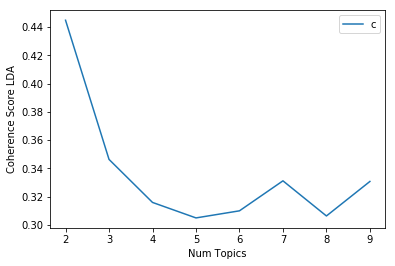

In [22]:
# Show graph
limit = 10; start=2; step=1
x = range(start, limit, step)
plt.plot(x, coherence_values_lda)
plt.xlabel("Num Topics")
plt.ylabel("Coherence Score LDA")
plt.legend(("coherence_values_lda"), loc="best")
plt.show()

In [23]:
# print coherence scores
for m, cv in zip(x, coherence_values_lda):
    print('Num Topics = ', m, ' has Coherence value of ', round(cv, 4))

Num Topics =  2  has Coherence value of  0.4449
Num Topics =  3  has Coherence value of  0.3464
Num Topics =  4  has Coherence value of  0.3159
Num Topics =  5  has Coherence value of  0.3049
Num Topics =  6  has Coherence value of  0.31
Num Topics =  7  has Coherence value of  0.3312
Num Topics =  8  has Coherence value of  0.3063
Num Topics =  9  has Coherence value of  0.3308


# NMF

Nonnegative matrix factorisation is also a topic modeling technique . It is a dimension reduction and factor analysis techniques . 

The aim of NMF is like LDA in which it tries to reduce the dimensions of the input matrix 
A(m * n) into a lesser dimension k << min(m,n) and form  two matrices W(m * k) and H(k * n) in such a  way that
A~WH and  min f(W,H)=||A-WH||^2 

The matrix W represents the cluster / topic matrix which represents the k topics and the matrix the ith column of matrix H represents the topic proportions of a(i) the document with ith index

In [ ]:
from IPython.display import Image
Image(filename="NMF.png")
#https://medium.com/ml2vec/topic-modeling-is-an-unsupervised-learning-approach-to-clustering-documents-to-discover-topics-fdfbf30e27df

For NMF, we need to obtain a design matrix. To obtain better results ,lets use a TfIdf transformation to the counts.

In [ ]:
df = pd.read_csv('abcnews-date-text.csv', error_bad_lines=False)

In [ ]:
train_headlines = df['headline_text']

In [ ]:
#the count vectorizer needs string inputs, not array, so I join them with a space.
train_headlines_sentences = list(train_headlines[:100000])

In [ ]:
train_headlines_sentences[:10]

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

In [ ]:
#obtain a Counts design matrix. Because the size of the matrix will be large, we can set the max_features to 5000.
vectorizer = CountVectorizer(analyzer='word', max_features=10000);
x_counts = vectorizer.fit_transform(train_headlines_sentences);

In [ ]:
vectorizer

In [ ]:
x_counts

In [ ]:
#set a TfIdf transformer, and transfer the counts with the model.
transformer = TfidfTransformer(smooth_idf=False);
x_tfidf = transformer.fit_transform(x_counts);

In [ ]:
from sklearn.preprocessing import normalize
#normalize the TfIdf values so each row has unit length.
xtfidf_norm = normalize(x_tfidf, norm='l1', axis=1)

In [ ]:
#obtain a NMF model.
model = NMF(n_components=10, init='nndsvd');

In [ ]:
#fit the model
import time 
start2 = time.time()
model.fit(xtfidf_norm)
print ('time to fit the model ' , time.time()-start2)

In [ ]:
model.components_[0]

In [ ]:
num_topics = 10

In [ ]:
def get_nmf_topics(model, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-20 - 1:-1] 
        #get the top 20 word ids for each topic 
        words = [feat_names[key] for key in words_ids] #obtain the word using the id
        word_dict['Topic ' + '{:01d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

In [ ]:
get_nmf_topics(model, 10)

# Hierarchical dirichilet process (HDP)

what if you do not know the ideal no of topics ?


HDP is an extension of LDA, designed to address the case where the number of "topics" in 
is not known a priori. 

Using LDA for topic modeling, one treats each "topic" as a distribution of words
in some known vocabulary. For each document a mixture of topics is drawn from a 
Dirichlet distribution i.e. P(t/d), and then each word in the document is an independent draw from that mixture (that is, selecting a topic and then using it to generate a word). P(w/t)

For HDP, one also uses a Dirichlet process to capture the uncertainty in the number of topics. So a common base distribution is selected which represents the countably-infinite set of possible topics for the corpus, and then the finite distribution of topics for each document is sampled from this base distribution.

As far as pros and cons, HDP has the advantage that the maximum number of topics can be unbounded and learned from the data rather than specified in advance. Although it would be more complicated to implement, and unnecessary in the case where a bounded number of topics is acceptable.

# How does HDP work 
takes a top down approach 
uses lDA dist to split a doc into topics and finds words associated with these topics 
Creates a doc for each of these topics which has only the words from Dirichilet dist 
Creates another LDA on this doc and keeps repeating until the doc is too small to model . 


In [ ]:
Image(filename="HLDA.png")

In [ ]:
from gensim.models.hdpmodel import HdpModel

In [ ]:
start3 = time.time()
Hdpmodel = HdpModel(corpus=bow_corpus,id2word=dictionary)
print ('time taken to train ', time.time()-start3)

In [ ]:
def get_hdp_topics(model, num_topics):
    word_dict = {}
    topics = model.show_topics(num_topics,20)
    word_dict = {'Topic '+str(i):[x.split('*') for x in words.split('+')] \
                 for i,words in lda_model.show_topics(10,20)}
    return pd.DataFrame.from_dict(word_dict)
get_hdp_topics(Hdpmodel, 10)

# GuidedLDA: Guided Topic modeling with latent Dirichlet allocation

In [ ]:
import guidedlda

In [ ]:
seed_topic_list = [['health', 'servic', 'industri'],
                   ['polic', 'charg', 'murder'],
                   ['report', 'warn', 'farmer', 'drought', 'storm'],
                   ['jail', 'reject', 'power'],
                   ['iraq', 'kill', 'bomb', 'soldier']]

In [ ]:
vec = CountVectorizer()
X = vec.fit_transform([' '.join(i) for i in processed_docs])
df = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
vocab = tuple(df.columns)
word2id = dict((v, idx) for idx, v in enumerate(vocab))

In [ ]:
model = guidedlda.GuidedLDA(n_topics=3, n_iter=100, random_state=7, refresh=20)

seed_topics = {}
for t_id, st in enumerate(seed_topic_list):
    for word in st:
        seed_topics[word2id[word]] = t_id

model.fit(X.toarray(), seed_topics=seed_topics, seed_confidence=0.001)

n_top_words = 12
topic_word = model.topic_word_
for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    print(' '.join(topic_words))